# Visualize Result of PHILHARMONIC Analysis

<a target="_blank" href="https://colab.research.google.com/github/samsledje/philharmonic/blob/main/nb/01_result_summary.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# @title Download and Install PHILHARMONIC

try:
    import importlib.util

    importlib.util.find_spec("google.colab")
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    !pip install philharmonic
    !curl https://current.geneontology.org/ontology/go.obo -o go.obo
    !curl https://current.geneontology.org/ontology/subsets/goslim_generic.obo -o goslim_generic.obo

from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from matplotlib import pyplot as plt

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
    plot_cluster,
    print_cluster,
    write_cluster_cytoscape,
)

In [5]:
# @title Loading PHILHARMONIC results
# @markdown Upload your zipped results file using the "Files" tab to the left.
# @markdown Set the `RUN_NAME` variable to the name of the run from your config file you want to analyze.
# @markdown If you are running this locally, edit the `RESULTS_DIR` variable to point to your results directory, and point to a locally downloaded go.obo file. Otherwise, you can leave it as is.

ZIP_FILE_NAME = ""  # @param {"type":"string","placeholder":"philharmonic_results.zip"}
RUN_NAME = "20240917-pdamAll-phil_v0.3.0"  # @param {"type":"string","placeholder":"philharmonic_run"}
RESULTS_DIR = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0"  # @param {"type":"string","placeholder":"."}

if IN_COLAB:
    !unzip -o $ZIP_FILE_NAME
    results_dir = Path(".")
    GO_OBO_PATH = "go.obo"
else:
    results_dir = Path(RESULTS_DIR)
    GO_OBO_PATH = results_dir / "go.obo"

CLUSTER_FILE_PATH = results_dir / f"{RUN_NAME}_clusters.json"
NETWORK_FILE_PATH = results_dir / f"{RUN_NAME}_network.positive.tsv"
GO_MAP_PATH = results_dir / f"{RUN_NAME}_GO_map.csv"
IMG_DIR = results_dir / "img"
!mkdir -p $IMG_DIR

clusters = load_cluster_json(CLUSTER_FILE_PATH)
full_G = nx.read_weighted_edgelist(NETWORK_FILE_PATH)
go_map = parse_GO_map(GO_MAP_PATH)
go_database = parse_GO_database(GO_OBO_PATH)

---

## Basic Network Statistics

In [6]:
label = ["Nodes", "Edges", "Degree (Med)", "Degree (Avg)", "Sparsity"]
degrees = [i[1] for i in list(full_G.degree())]
value = [
    len(full_G.nodes),
    len(full_G.edges),
    np.median(degrees),
    np.mean(degrees),
    len(full_G.edges()) / len(full_G) ** 2,
]
df = pd.DataFrame([label, value]).T
df.columns = ["", "Network"]
df = df.set_index("")
df

,Network
,
Nodes,7267
Edges,348278
Degree (Med),37.0
Degree (Avg),95.851933
Sparsity,0.006595


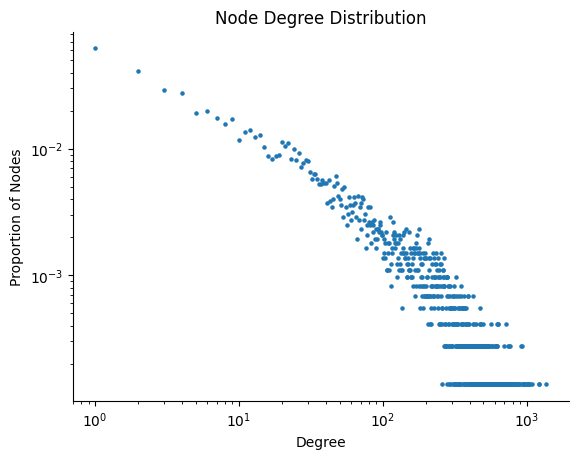

In [7]:
degreeDist = {}
for i in degrees:
    n = degreeDist.setdefault(i, 0)
    degreeDist[i] = n + 1

plt.scatter(degreeDist.keys(), [i / len(full_G) for i in degreeDist.values()], s=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Proportion of Nodes")
plt.title("Node Degree Distribution")
plt.savefig(IMG_DIR / "degree_distribution.svg", bbox_inches="tight", dpi=300)
sns.despine()

---

## Basic Cluster Statistics

In [8]:
logger.info(f"Number of clusters: {len(clusters)}")

2025-01-06 13:41:08.192 | INFO     | __main__:<module>:1 - Number of clusters: 468


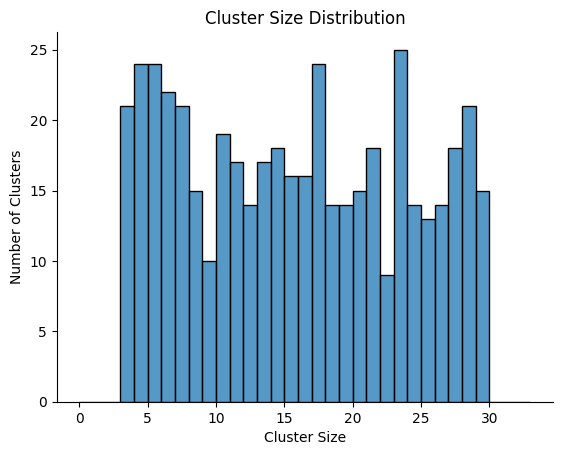

In [9]:
sizes = [len(i["members"]) for i in clusters.values()]
sns.histplot(sizes, bins=np.arange(0, max(sizes) + 5, max(max(sizes) // 20, 1)))
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.title("Cluster Size Distribution")
sns.despine()
plt.savefig(IMG_DIR / "size_distribution.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## Overall ReCIPE Stats

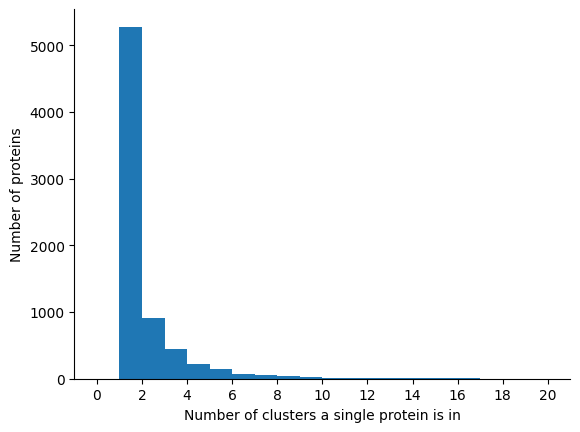

In [10]:
from collections import Counter

node_appearances = list()
for clust in clusters.values():
    for mn in clust["members"]:
        node_appearances.append(mn)
    for rn in clust["recipe"]["degree"]["0.75"]:
        node_appearances.append(rn)
nodes_counter = Counter(node_appearances)
plt.hist(nodes_counter.values(), bins=np.arange(0, 21, 1))
# xtick labels every 5
plt.xticks(np.arange(0, 21, 2))
plt.xlabel("Number of clusters a single protein is in")
plt.ylabel("Number of proteins")
sns.despine()
plt.savefig(IMG_DIR / "protein_number_of_clusters.png", bbox_inches="tight", dpi=300)
plt.show()

---

## View Individual Clusters

In [12]:
k = "1238085533603602511"  # @param {"type":"string","placeholder":"cluster_id"}

if k == "":
    k = list(clusters.keys())[0]
    print(f"No cluster ID specified, using first cluster: {k}")

Cluster of 14 proteins [pdam_00015176-RA, pdam_00017668-RA, pdam_00021182-RA, ...] (hash 1238085533603602511)
6 proteins re-added by ReCIPE (degree, 0.75)
Edges: 0
Triangles: 0
Max Degree: 0
Top Terms:
		GO:0007596 - <blood coagulation> (7)
		GO:0030168 - <platelet activation> (6)
		GO:0045986 - <negative regulation of smooth muscle contraction> (6)
		GO:0045907 - <positive regulation of vasoconstriction> (6)
		GO:0006954 - <inflammatory response> (6)
		GO:0019233 - <sensory perception of pain> (6)
		GO:0032496 - <response to lipopolysaccharide> (6)
		GO:0070374 - <positive regulation of ERK1 and ERK2 cascade> (6)
		GO:0007601 - <visual perception> (5)
		GO:0035025 - <positive regulation of Rho protein signal transduction> (5)
		GO:0002032 - <obsolete desensitization of G protein-coupled receptor signaling pathway by arrestin> (4)
		GO:0022400 - <regulation of opsin-mediated signaling pathway> (4)
		GO:0051586 - <positive regulation of dopamine uptake involved in synaptic transmission>

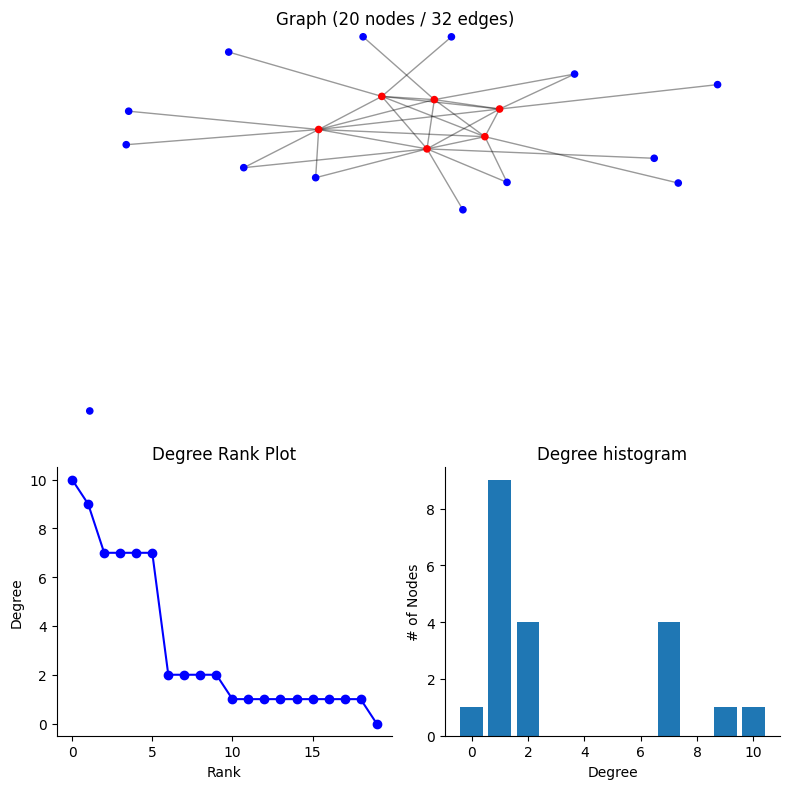

All cluster members:
	pdam_00015176-RA
	pdam_00017668-RA
	pdam_00021182-RA
	pdam_00024915-RA
	pdam_00021410-RA
	pdam_00002706-RA
	pdam_00015466-RA
	pdam_00016473-RA
	pdam_00012939-RA
	pdam_00002146-RA
	pdam_00016767-RA
	pdam_00000276-RA
	pdam_00008890-RA
	pdam_00013906-RA


In [16]:
print_cluster(clusters[k], go_database, 20)
plot_cluster(clusters[k], full_G, use_recipe=True, savefig=None)

print("All cluster members:")
for m in clusters[k]["members"]:
    print(f"\t{m}")

In [27]:
write_cluster_cytoscape(clusters[k], full_G, str(results_dir / f"{k}_cytoscape.txt"))